# Topic: Malaria Detection Via Cell Images
## Scope: Healthcare
### Project Team: LSTM


---

Dataset can be found [here](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria).




# A. Image Analysis & Preprocessing

## 1. Load the dataset from Kaggle to Google Colab [(link)](https://www.kaggle.com/general/74235) 
Just download and add your Kaggle API Token

In [1]:
!pip install kaggle

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
# !kaggle datasets download -d nipunarora8/malaria-detection-dataset --unzip
!kaggle datasets download iarunava/cell-images-for-detecting-malaria

 98% 662M/675M [00:04<00:00, 152MB/s]
100% 675M/675M [00:04<00:00, 147MB/s]


In [4]:
!unzip "/content/cell-images-for-detecting-malaria.zip"

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [5]:
!ls cell_images

cell_images  Parasitized  Uninfected


## 2. Importing the required libraries and modules

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import cv2
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [7]:
shutil.rmtree('/content/cell_images/cell_images')

## 3. Loading the images
Printing random 5 images from each categories - Parasite & Uninfected

### Configuring the path of the categories in the dataset

In [8]:
parasitized_dir = '/content/cell_images/Parasitized'
uninfected_dir = '/content/cell_images/Uninfected'
dataset_dir = '/content/cell_images'

In [9]:
def load_random_imgs_from_folder(folder):
  plt.figure(figsize=(20,20))
  for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.xlabel(f'Image Shape: {img.shape}')
    plt.imshow(img)

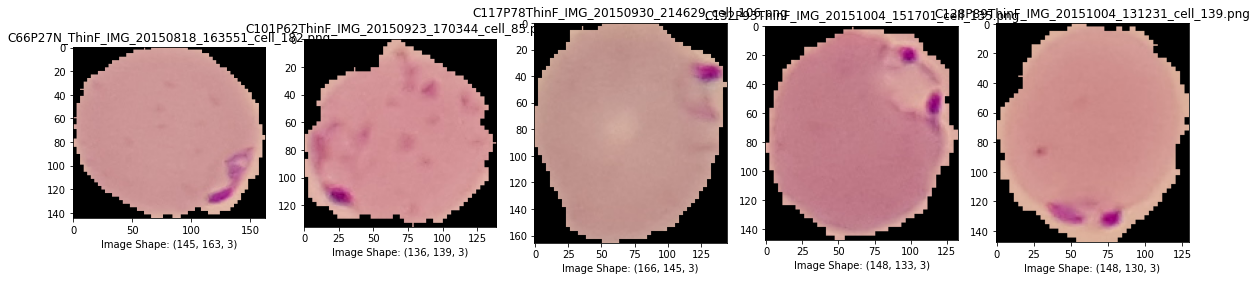

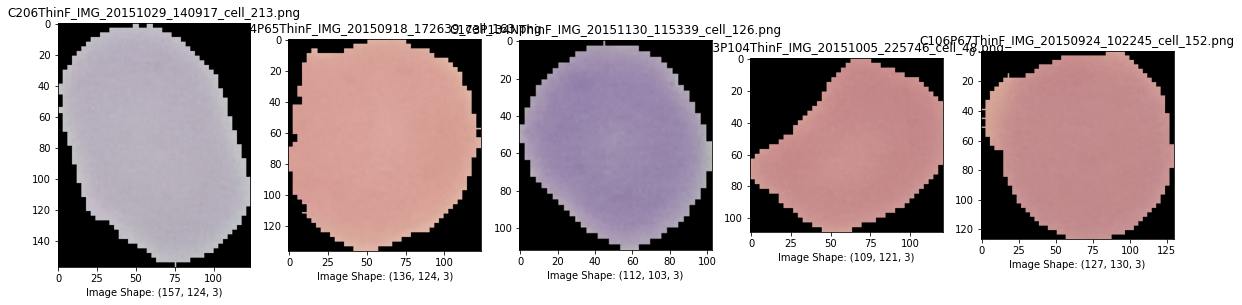

In [10]:
load_random_imgs_from_folder(parasitized_dir)
print('\n\n')
load_random_imgs_from_folder(uninfected_dir)

## 4. Renaming the datasets

In [11]:
def rename_imgs(category, path):
  # print(os.getcwd())
  os.chdir(path)
  print(os.getcwd())
  for index, filename in enumerate(os.listdir(".")):
    # print(filename, index)
    os.rename(filename, f'{category}_{index+1}.png')
    # print(filename)
  print(f'Renaming {category} Category Successful')

In [12]:
rename_imgs('Parasitized', parasitized_dir)
rename_imgs('Uninfected', uninfected_dir)

/content/cell_images/Parasitized
Renaming Parasitized Category Successful
/content/cell_images/Uninfected
Renaming Uninfected Category Successful


## 5. Create database and splitting to train, test and val

In [13]:
IMG_SIZE = 64 # downscaled to fit the lowest height and width of the train images
# IMG_SIZE = 224 # usually used size for CNN architecture
# IMG_SIZE = 128

In [14]:
classes=[]
for i in os.listdir(dataset_dir):
  classes+=[i]

print(classes)

['Parasitized', 'Uninfected']


In [15]:
def create_dataset(data_dir):
    data = [] 
    for label in classes: 
        path = os.path.join(data_dir, label)
        class_num = classes.index(label)
        for img in os.listdir(path):
            try:
              if img[-3:] != 'txt':
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [16]:
dataset = create_dataset(dataset_dir)
np.random.shuffle(dataset)

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


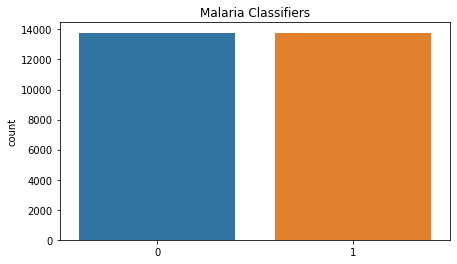

In [17]:
# plot to check the balance of the classes in the dataset

plt.figure(figsize=(7,4))
sns.countplot(dataset[:,1]);
plt.title('Malaria Classifiers');

In [18]:
len(dataset)*0.6

16534.8

In [19]:
train = dataset[:16534]
val = dataset[16534:22046]
test = dataset[22046:]

In [20]:
train_df = pd.DataFrame(train, columns=['Images', 'Label'])

In [21]:
# train_df.head(5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


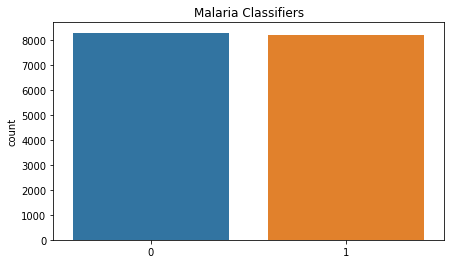

In [22]:
#  plotting the count of classes in train dataset

plt.figure(figsize=(7,4))
sns.countplot(train[:,1]);
plt.title('Malaria Classifiers');

In [23]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)


## 6. Image Pre-processing

### 6.1. Normalizing the dataset

In [24]:
type(x_train)

list

In [25]:
x_train = np.array(x_train) / 255.0
y_train = np.array(y_train)
x_val = np.array(x_val) / 255.0
y_val = np.array(y_val)

In [26]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)

In [27]:
type(x_train)

numpy.ndarray

In [28]:
print(f"Shape of x_train --> {x_train.shape} & y_train --> {y_train.shape}")
print(f"Shape of x_val --> {x_val.shape} & y_val --> {y_val.shape}")
print(f"Shape of x_test --> {x_test.shape} & y_test --> {y_test.shape}")

Shape of x_train --> (16534, 64, 64, 3) & y_train --> (16534,)
Shape of x_val --> (5512, 64, 64, 3) & y_val --> (5512,)
Shape of x_test --> (5512, 64, 64, 3) & y_test --> (5512,)


### 6.2. Filtering noise using OpenCV

In [29]:
def plot_before_after(img, filtered_img):
  """
  Function to plot before and after the images are filtered
  
  """
  plt.figure(figsize=(10,10))
  plt.subplot(121),plt.imshow(img),plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(filtered_img),plt.title('Filtered')
  plt.xticks([]), plt.yticks([])
  plt.show()

In [32]:
class Filters:
  def __init__(self, x_train):
    self.x_train = x_train
  
  def Gaussian_Blurr(self, kernel):
    self.kernel = kernel
    gauss_blurr = []
    for i in range(len(self.x_train)-1):
      f_img = cv2.GaussianBlur(self.x_train[i], self.kernel,0)
      gauss_blurr.append(f_img)
    return gauss_blurr

  def Median_Blurr(self, K):
    self.K = K
    median_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32')
      f_img = cv2.medianBlur(img, self.K)
      median_blurr.append(f_img)
    return median_blurr

  def Bilateral_Blurr(self, diameter, sigmaColor, sigmaSpace):
    self.d = diameter
    self.sc = sigmaColor
    self.ss = sigmaSpace
    bilateral_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32')
      f_img = cv2.bilateralFilter(img, self.d, self.sc, self.ss)
      bilateral_blurr.append(f_img)
    return bilateral_blurr


In [33]:
img_filter = Filters(x_train)

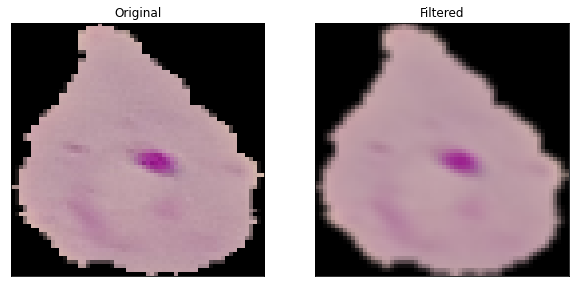

In [34]:
gauss_imgs = img_filter.Gaussian_Blurr((3,3))
plot_before_after(x_train[4], gauss_imgs[4])

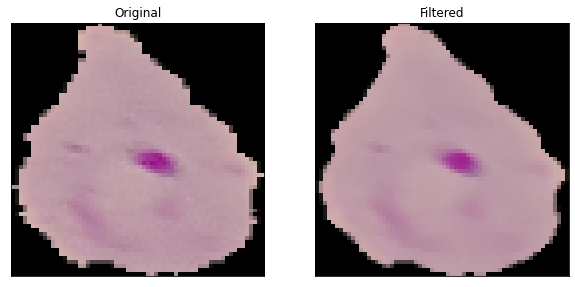

In [35]:
medians = img_filter.Median_Blurr(3)
plot_before_after(x_train[4], medians[4])

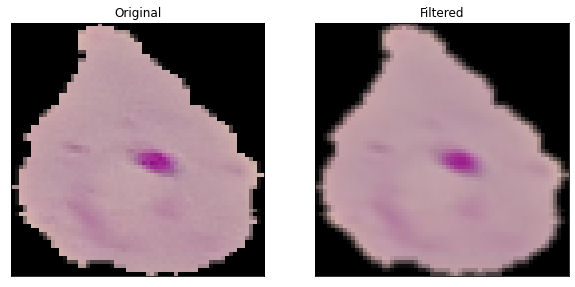

In [42]:
bilateral_imgs = img_filter.Bilateral_Blurr(3, 11, 5)
plot_before_after(x_train[4], bilateral_imgs[4])

### Reshaping the images to 1D array to be fed to the model

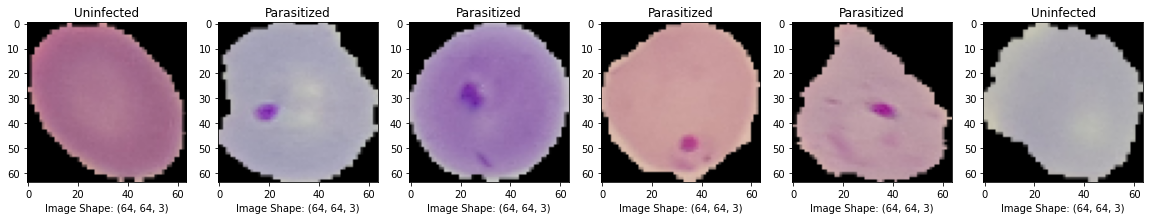

In [37]:
## plotting the renamed, resized & normalized images

plt.figure(figsize=(20,20))

for i in range(6):
  img = x_train[i]
  ax=plt.subplot(1,6,i+1)
  ax.title.set_text(classes[y_train[i]])
  plt.xlabel(f'Image Shape: {img.shape}')
  plt.imshow(img)


In [38]:
# new_dim = np.prod(x_train.shape[1:])
# x_train = x_train.reshape(x_train.shape[0], new_dim)
# x_val = x_val.reshape(x_val.shape[0], new_dim)
# x_test = x_test.reshape(x_test.shape[0], new_dim)

## 7. Data Augmentation

In [39]:
# train_datagen = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20,  
#                                      fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
#                                      width_shift_range = 0.1, height_shift_range = 0.1)


# train_datagen.fit(x_train)

# 2. Model Implementation

### 1.1 Functions

In [40]:
def learning_curve(model_fit, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [41]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels[::-1]);
    plt.show()